In [1]:
## This is the notebook to detect the crosswalk  (but not from aerial images)
## dataset directory : pedestrain_data/

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
base_dir ='./pedestrain_data/' 

In [5]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

In [6]:
train_crossings_dir = os.path.join(train_dir, 'crossings')  # directory with our training cat pictures
train_no_crossing_dir = os.path.join(train_dir, 'no_crossings')  # directory with our training dog pictures
validation_crossing_dir = os.path.join(validation_dir, 'crossings')  # directory with our validation cat pictures
validation_no_crossing_dir = os.path.join(validation_dir, 'no_crossings')

In [7]:
num_crossing_tr = len(os.listdir(train_crossings_dir))
num_no_crossing_tr = len(os.listdir(train_no_crossing_dir))

num_crossing_val = len(os.listdir(validation_crossing_dir))
num_no_crossing_val = len(os.listdir(validation_no_crossing_dir))

total_train = num_crossing_tr  + num_no_crossing_tr
total_val = num_crossing_val + num_no_crossing_val

In [8]:
print('total training cat images:', num_crossing_tr)
print('total training dog images:', num_no_crossing_tr)

print('total validation cat images:', num_crossing_val)
print('total validation dog images:', num_no_crossing_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1025
total training dog images: 40
total validation cat images: 311
total validation dog images: 17
--
Total training images: 1065
Total validation images: 328


In [9]:
BATCH_SIZE = 5
IMG_SHAPE  = 500 # 

In [10]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [11]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      vertical_flip=True,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest'
)

In [12]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE),class_mode='binary')

Found 1064 images belonging to 2 classes.


In [13]:
train_data_gen.class_indices

{'crossings': 0, 'no_crossings': 1}

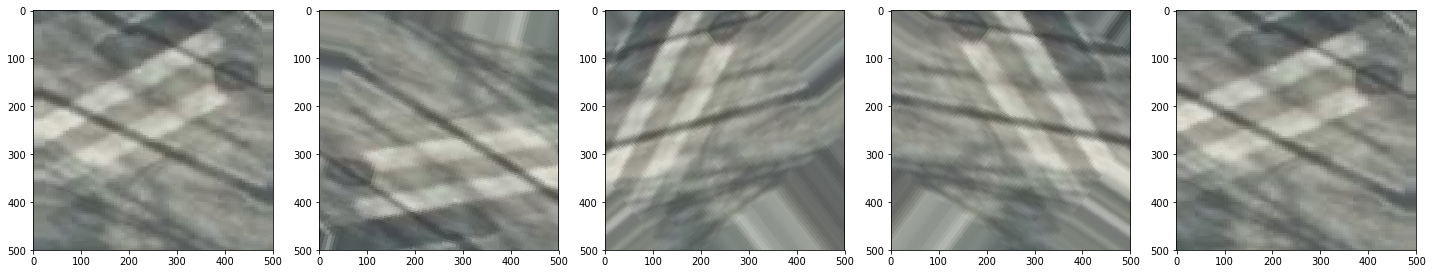

In [14]:
augmented_images = [train_data_gen[4][0][0] for i in range(5)]
plotImages(augmented_images)

In [15]:
### Creating validation 

In [16]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 326 images belonging to 2 classes.


In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(500, 500, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [18]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 498, 498, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 247, 247, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 123, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 121, 128)     73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 60, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 128)       0

In [ ]:
epochs=10
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()